<a href="https://colab.research.google.com/github/phelchegs/bms-molecular-translation/blob/main/InChI_work_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install all necessary packages. RDKit is used for pics of mol structures for extra dataset.
#
!pip install rdkit
!pip install einops
!pip install GPUtil
!pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=620bf7e81b60ecbf9afd7382e5941ce5e15e97cf1339a40f71d6c0b3df07f73a
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [ ]:
#import kaggle beta API to download the data to 'Files' folder.

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=bf3f2cb4702eaf4a3cb694e07330b255529be2ee8832acb80f32823c431620ee
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [ ]:
#Dowwnload.
!kaggle competitions download -c 'bms-molecular-translation'

100% 7.81G/7.82G [01:18<00:00, 81.0MB/s]
100% 7.82G/7.82G [01:18<00:00, 106MB/s] 


In [ ]:
#Unzip. It will take a long time.
!mkdir bms-molecular-translation
!unzip bms-molecular-translation.zip -d bms-molecular-translation

In [ ]:
#Show the high-RAM property.
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
#Show CUDA and GPU.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Sep 22 13:58:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Mount the path to content/drive
#sys.path.append allows us to call the .py files in drive/MyDrive.
import os
import sys
from google.colab import drive

drive.mount("/content/drive")
sys.path.append("/content/drive/MyDrive/deep learning project-chemical recognition")

Mounted at /content/drive


In [ ]:
#Import packages, .py files is used for the transformer model and the InChI dataset preprocessing.
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import KFold

from InChI_tokenizer import Tokenizer
from InChI_preprocessing import split_form, train_file_path, get_atom_counts, crop_image, pad_image, preprocess_train_images, get_transform, get_aug
from InChI_dataset import Extra_inchi_save_ds, MolecularTranslationDataModule
from InChI_tokenizer import Tokenizer
from utils_InChI_translate import shape_after_crop, run_one_epoch, DummyOptimizer, DummyScheduler, Train_Counter

import cv2
import rdkit.Chem as Chem

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from Transformer_decoder import subsequent_mask
from Transformer_embedding import TGT_Embedding
from cnn_ViT_transformer import ViT_transformer
import utils
import MNIST_example
import altair as alt
import copy
import math
from torch import nn
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import GPUtil

In [ ]:
#Define the configuration class. Note that the max_text_len and vocab_length are obtained from the later cells, which means this cell needs to rerun after obtaining those 2 parameters.

class CFG:
    #environment
    device = 0

    #general
    seed = 1987

    #dataset
    batch_size = 64

    #preprocess
    trans_type = 'rotate90 or verticalflip'
    pixels_mean = (0.485)
    pixels_std = (0.229)
    crop = True

    #key parameter
    #max_crop_size = 1485
    max_text_len = 268

    #extra InChI path
    extra_InChI_image_dir = './bms-molecular-translation/train_extra'

    #hyperparameters
    num_epochs = 15
    num_folds = 15

    #model for original ViT transformer
    patch_dim = 64 #dimension of patch for vision part in ViT
    encoder_layers = 6
    encoder_heads = 3
    encoder_one_head_dim = 256
    encoder_ff_dim = 512
    dropout = 0.1 #use one dropout throughout the ViT model for simplicity
    token_dim = 32
    decoder_layers = 6
    decoder_heads = 3
    decoder_one_head_dim = 256
    decoder_ff_dim = 512

    #model for Resnet18 image encoder

    num_channels = 1
    pretrained = True

    #image params
    image_size = 224
    patch_size = 16
    channels = 1

    vocab_length = 175

In [ ]:
#Load training and extra datas. Note that too large dataset will be computationally costy, even GPU and high-RAM cannot handle it.
train = pd.read_csv('./bms-molecular-translation/train_labels.csv')
extra = pd.read_csv('./bms-molecular-translation/extra_approved_InChIs.csv')
extra = extra.loc[:100000, :]
train = train.loc[:100000, :]
print('Read in train and extra dataset. Train shape: {}, Extra shape: {}.' \
      .format(train.shape, extra.shape))

Read in train and extra dataset. Train shape: (100001, 2), Extra shape: (100001, 1).


In [ ]:
#Tokenize the InChI text. First split the texts to Formula and InChI text two parts. Then split InChI texts to tokens.
print('Obtain new column of formula and inchi text that will be used for tokenizing.')
train['Formula'] = train['InChI'].progress_apply(lambda x: x.split('/')[1])
train['InChI_text'] = train['InChI'].progress_apply(lambda x: split_form(x[9:]))

extra['Formula'] = extra['InChI'].progress_apply(lambda x: x.split('/')[1])
extra['InChI_text'] = extra['InChI'].progress_apply(lambda x: split_form(x[9:]))

Obtain new column of formula and inchi text that will be used for tokenizing.


  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

In [ ]:
#Use InChI tokenizer to tokenize InChI text and save the vocab dictionary.
tokenizer = Tokenizer()
tokenizer.gen_vocab_dict(np.concatenate((train['InChI_text'].values, extra['InChI_text'].values)))
torch.save(tokenizer, './bms-molecular-translation/tokenizer.pth')
print('Saved tokenizer')
#Load the tokenizer.
# tokenizer = torch.load('./bms-molecular-translation/tokenizer.pth')

Saved tokenizer


In [ ]:
# optional, load the tokenizer
# tokenizer = torch.load('./bms-molecular-translation/tokenizer.pth')

In [ ]:
#Create the column 'file_path'based on the column 'id'.
train['file_path'] = train['image_id'].apply(train_file_path)

In [ ]:
#Optional. Save the datasets as .pkl files.
train.to_pickle('./bms-molecular-translation/train1.pkl')
extra.to_pickle('./bms-molecular-translation/extra1.pkl')

In [ ]:
#Optional. Save train/extra ds from the .pkl files.
# train = pd.read_pickle('./bms-molecular-translation/train1.pkl')
# extra = pd.read_pickle('./bms-molecular-translation/extra1.pkl')

In [ ]:
#Create columns that show the counts of individual atoms, such as C, H, O, S, N, etc. Not directly related to the translation goal.
#Cannot complete for the limited RAM.
train = get_atom_counts(train)
extra = get_atom_counts(extra)

100%|██████████| 100001/100001 [00:00<00:00, 109342.83it/s]


In [ ]:
#Preprocess the training dataset. Create the column of text length.
train_text_len = []
tk0 = tqdm(train['InChI_text'].values, total = len(train))
for text in tk0:
    seq = tokenizer.text_to_sequence(text)
    length = len(seq) - 2
    train_text_len.append(length)
train['text_length'] = train_text_len
train.to_pickle('./bms-molecular-translation/train1.pkl')
print('Saved preprocessed train1.pkl')

  0%|          | 0/100001 [00:00<?, ?it/s]

Saved preprocessed train1.pkl


In [ ]:
#Create the folder for extra training data.
!mkdir bms-molecular-translation/train_extra

In [ ]:
#Generate extra images of mol structures. Save them in the train extra folder.
extra.reset_index(inplace = True)
extra = extra.rename(columns={'index': 'ids'})
extra_dataset_obj = Extra_inchi_save_ds(extra, tokenizer, CFG, transform = None)
extra_text_len = []
for i in tqdm(range(extra.shape[0])):
    seq_length = extra_dataset_obj[i]
    extra_text_len.append(seq_length - 2)
#Create the text_length and file_path columns
extra['text_length'] = extra_text_len
extra['file_path'] = './bms-molecular-translation/train_extra/extra_' + extra['ids'].apply(str) + '.png'
#Save the extra training dataset.
extra.to_pickle('./bms-molecular-translation/extra1.pkl')
print('Saved preprocessed extra.pkl')

  0%|          | 0/100001 [00:00<?, ?it/s]

Saved preprocessed extra.pkl


In [ ]:
#Optional, check the columns' names of extra and train dataset.
# extra.head()

,ids,InChI,Formula,InChI_text,B,Br,C,Cl,F,H,I,N,O,P,S,Si,text_length,file_path
0,0,InChI=1S/C13H10Cl4O4/c1-20-13(21-2)11(16)5-6-8...,C13H10Cl4O4,C 13 H 10 Cl 4 O 4 /c 1 - 20 - 13 ( 21 - 2 ) 1...,0,0,13,4,0,10,0,0,4,0,0,0,99,./bms-molecular-translation/train_extra/extra_...
1,1,InChI=1S/C23H32O6Si/c1-20(2)25-15-19(27-20)22(...,C23H32O6Si,C 23 H 32 O 6 Si /c 1 - 20 ( 2 ) 25 - 15 - 19 ...,0,0,23,0,0,32,0,0,6,0,0,1,117,./bms-molecular-translation/train_extra/extra_...
2,2,InChI=1S/C24H16N4O3/c29-21-19-20(14-8-2-1-3-9-...,C24H16N4O3,C 24 H 16 N 4 O 3 /c 29 - 21 - 19 - 20 ( 14 - ...,0,0,24,0,0,16,0,4,3,0,0,0,106,./bms-molecular-translation/train_extra/extra_...
3,3,InChI=1S/C20H26N2O5/c1-9-14-11-7-13-19(8-21-3)...,C20H26N2O5,C 20 H 26 N 2 O 5 /c 1 - 9 - 14 - 11 - 7 - 13 ...,0,0,20,0,0,26,0,2,5,0,0,0,125,./bms-molecular-translation/train_extra/extra_...
4,4,InChI=1S/C14H12BrN/c15-8-3-1-7(2-4-8)12-9-5-10...,C14H12BrN,C 14 H 12 Br N /c 15 - 8 - 3 - 1 - 7 ( 2 - 4 -...,0,1,14,0,0,12,0,1,0,0,0,0,81,./bms-molecular-translation/train_extra/extra_...


In [ ]:
#Optional, check the columns' names of extra and train dataset.
# train.head()

,image_id,InChI,Formula,InChI_text,file_path,B,Br,C,Cl,F,H,I,N,O,P,S,Si,text_length
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,C13H20OS,C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...,./bms-molecular-translation/train/0/0/0/000011...,0,0,13,0,0,20,0,0,1,0,1,0,59
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,C21H30O4,C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8...,./bms-molecular-translation/train/0/0/0/000019...,0,0,21,0,0,30,0,0,4,0,0,0,108
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,C24H23N5O4,C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 ...,./bms-molecular-translation/train/0/0/0/000025...,0,0,24,0,0,23,0,5,4,0,0,0,112
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,C17H24N2O4S,C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 (...,./bms-molecular-translation/train/0/0/0/000026...,0,0,17,0,0,24,0,2,4,0,1,0,108
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,C10H19N3O2S,C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 -...,./bms-molecular-translation/train/0/0/0/000026...,0,0,10,0,0,19,0,3,2,0,1,0,72


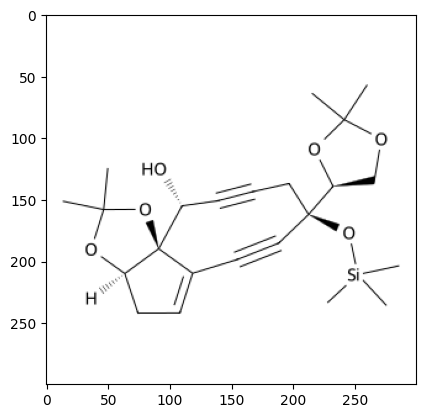

In [ ]:
#Demo of extra image.
image = cv2.imread(extra['file_path'][1]).astype(np.uint8)
plt.imshow(image)

In [ ]:
#Concat train and extra dataset.
# train = pd.read_pickle('./bms-molecular-translation/train1.pkl')
# extra = pd.read_pickle('./bms-molecular-translation/extra1.pkl')
# tokenizer = torch.load('./bms-molecular-translation/tokenizer.pth')
full  = pd.concat([train[['InChI_text', 'file_path', 'text_length']], extra[['InChI_text', 'file_path', 'text_length']]], axis = 0).reset_index(drop = True)
#max_size = shape_after_crop(full)

In [ ]:
#Preprocess the images in full dataset. Including resize, add noise, and randomly selected transformation from vertical flip and rotate. The whole process will double the amount of full dataset.
#Each original image will have a flipped or rotated copy that has the identical caption, the InChI text.
full_df = preprocess_train_images(full, get_transform, CFG)

100%|██████████| 200002/200002 [08:24<00:00, 396.67it/s]


In [ ]:
#Optional, check the columns' names of extra and train dataset.
# full_df.head()

,InChI_text,file_path,text_length,image
0,C 21 H 25 N O 5 /c 1 - 15 - 5 - 7 - 16 ( 8 - 6...,./bms-molecular-translation/train/0/4/4/044921...,82,"[[[0], [0], [255], [0], [0], [0], [0], [0], [2..."
1,C 12 H 23 N 3 O /c 1 - 9 ( 2 ) 11 - 4 - 3 - 7 ...,./bms-molecular-translation/train/0/1/d/01d620...,64,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
2,C 16 H 25 Br N 2 /c 1 - 18 - 11 - 14 - 8 - 9 -...,./bms-molecular-translation/train_extra/extra_...,74,"[[[0], [0], [0], [0], [255], [255], [255], [0]..."
3,C 19 H 19 N 3 O 5 /c 1 - 12 - 3 - 5 - 14 ( 6 -...,./bms-molecular-translation/train_extra/extra_...,109,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
4,C 17 H 18 N 4 O S /c 18 - 16 ( 22 ) 15 - 5 - 1...,./bms-molecular-translation/train/0/0/3/003631...,88,"[[[255], [0], [0], [255], [0], [0], [0], [0], ..."


In [ ]:
#Optional. Save the full_df ds as .pkl files.
full_df.to_pickle('./bms-molecular-translation/fulldf1.pkl')
# full_df = pd.read_pickle('./bms-molecular-translation/fulldf1.pkl')

In [ ]:
#Prepare for the cross validation. Create the column fold to show which ones will be used for validation in individual epoch.
kf = KFold(n_splits = CFG.num_folds, shuffle = True, random_state = CFG.seed)
for i, (train_idx, val_idx) in enumerate(kf.split(full_df)):
    full_df.loc[val_idx, 'fold'] = i
full_df['fold'] = full_df['fold'].astype(int)
full_df['fold'].value_counts()

5     26667
11    26667
12    26667
1     26667
3     26667
10    26667
6     26667
9     26667
2     26667
8     26667
0     26667
13    26667
4     26667
7     26667
14    26666
Name: fold, dtype: int64

In [ ]:
#Check max_text_len, if this NO. changes, go back to class CFG and modify it.
max_text_len = full_df['text_length'].max()
text_len = max_text_len + 2
text_len

268

In [ ]:
#Check vocab length, if this NO. changes, go back to class CFG and modify it.
len(tokenizer.text2index)

175

In [ ]:
#Train the model, cross validate it, and save it as InChItrainslationfinalmodel.pt.
#Note that run_one_epoch in utils_InChI has been modified to show the live translation, Bleu score, and validation loss.
gpu = 0
print(f"Train worker process using GPU: {gpu} for training", flush = True)
torch.manual_seed(CFG.seed)
torch.cuda.set_device(gpu)
loss_func = utils.loss_function(CFG.vocab_length, tokenizer.text2index['<pad>'])
loss_func.cuda(gpu)
test_model = ViT_transformer(num_channels = CFG.num_channels,
                             pretrained = CFG.pretrained,
                              src_dim = 49,
                              token_dim = CFG.token_dim,
                              decoder_layers = CFG.decoder_layers,
                              decoder_heads = CFG.decoder_heads,
                              decoder_one_head_dim = CFG.decoder_one_head_dim,
                              decoder_ff_dim = CFG.decoder_ff_dim,
                              decoder_dropout = CFG.dropout,
                              vocab_length = CFG.vocab_length,
                              tgt_embedding_dropout = CFG.dropout,
                              tgt_max = CFG.max_text_len)
test_model.cuda(gpu)

optimizer = torch.optim.Adam(
    test_model.parameters(), lr = 0.5, betas = (0.9, 0.98), eps = 1e-9
)

lr_scheduler = LambdaLR(
    optimizer = optimizer,
    lr_lambda = lambda step: utils.lr_scheduler(
        step, model_size= test_model.tgt_embedding.token_dim, factor = 1.0, warmup_step = 400
    ),
)

for epoch in range(CFG.num_epochs):
    valid_df = full_df.loc[full_df['fold'] == epoch]
    train_df = full_df.loc[full_df['fold'] != epoch]
    ds = MolecularTranslationDataModule(train_df, valid_df, tokenizer, CFG, get_aug(CFG))
    test_model.train()
    print(f"Now Training Epoch {epoch} ====", flush = True)
    _, train_state = run_one_epoch(
      (utils.Batchify(b[0], b[1], tokenizer.text2index['<pad>'], CFG.device) for b in ds.train_dataloader()),
      test_model,
      loss_func,
      optimizer,
      lr_scheduler,
      CFG,
      tokenizer,
      mode = "train",
      train_state = Train_Counter(),
      start_idx = tokenizer.text2index['<sos>']
    )
    GPUtil.showUtilization()
    torch.cuda.empty_cache()

    test_model.eval()
    with torch.no_grad():
      print(f"Now Validating Epoch {epoch} ====", flush = True)
      sloss = run_one_epoch(
          (utils.Batchify(b[0], b[1], tokenizer.text2index['<pad>'], CFG.device) for b in ds.val_dataloader()),
          test_model,
          loss_func,
          DummyOptimizer(),
          DummyScheduler(),
          CFG,
          tokenizer,
          mode= 'validation',
          train_state = Train_Counter(),
          start_idx = tokenizer.text2index['<sos>']
      )
      print("Validation Loss {}".format(sloss))
    torch.cuda.empty_cache()
torch.save(test_model.state_dict(), "InChItrainslationfinalmodel.pt")

Train worker process using GPU: 0 for training


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


Now Training Epoch 0 ====
Batch      1 in the current epoch | Loss / Token:   5.58 | Tokens / Sec:  3175.3 | Learning Rate: 2.2e-05
Batch    101 in the current epoch | Loss / Token:   2.20 | Tokens / Sec:  8892.2 | Learning Rate: 1.1e-03
Batch    201 in the current epoch | Loss / Token:   1.90 | Tokens / Sec:  8219.9 | Learning Rate: 2.2e-03
Batch    301 in the current epoch | Loss / Token:   1.69 | Tokens / Sec:  8042.5 | Learning Rate: 3.3e-03
Batch    401 in the current epoch | Loss / Token:   1.65 | Tokens / Sec:  7996.2 | Learning Rate: 4.4e-03
Batch    501 in the current epoch | Loss / Token:   1.51 | Tokens / Sec:  7989.9 | Learning Rate: 3.9e-03
Batch    601 in the current epoch | Loss / Token:   1.49 | Tokens / Sec:  8018.8 | Learning Rate: 3.6e-03
Batch    701 in the current epoch | Loss / Token:   1.43 | Tokens / Sec:  8039.2 | Learning Rate: 3.3e-03
Batch    801 in the current epoch | Loss / Token:   1.37 | Tokens / Sec:  7992.3 | Learning Rate: 3.1e-03
Batch    901 in the 